In [1]:
from config import*
from Maxwell import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  26569


In [2]:
WPINN_model = WPINN(input_size = n_collocation, 
                    num_hidden_layers1 = 2, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons = 50, 
                    family_size = len_family).to(device)

optimizer1 = optim.Adam(WPINN_model.parameters(), lr=1e-5)

def lr_lambda(epoch):
    if epoch < 5000: return 1.0      
    else: return 0.1     

scheduler = optim.lr_scheduler.LambdaLR(optimizer1, lr_lambda=lr_lambda)

In [3]:
x_interior = x_collocation.clone()
t_interior = t_collocation.clone()

def wpinn_loss(model):   
    global c, b
    c, b = model(x_interior, t_interior)

    E_pred_ic = torch.mv(Wic, c[0]) + b[0]
    H_pred_ic = torch.mv(Wic, c[1]) + b[1]
    
    E_pred_bc_left = torch.mv(Wbc_left, c[0]) + b[0]
    E_pred_bc_right = torch.mv(Wbc_right, c[0]) + b[0]
    D_H_pred_bc_left = torch.mv(DWbc_left, c[1])
    D_H_pred_bc_right = torch.mv(DWbc_right, c[1])


    E_x = torch.mv(DWx, c[0])
    E_t = torch.mv(DWt, c[0])
    H_x = torch.mv(DWx, c[1])
    H_t = torch.mv(DWt, c[1])

    
    pde_loss = torch.mean((E_x + H_t) ** 2) + torch.mean((H_x + E_t) ** 2)

    ic_loss = torch.mean((E_pred_ic - E_ic)**2) + torch.mean((H_pred_ic - H_ic)**2)

    bc_loss = torch.mean(E_pred_bc_left**2) + torch.mean(E_pred_bc_right**2) +\
              torch.mean(D_H_pred_bc_left**2) + torch.mean(D_H_pred_bc_right**2)
    
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

def train_wpinn(model, optimizer, num_epochs, num_prints):
    # Training loop
    pde_losses = []
    bc_losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()

        total_loss, pde_loss, ic_loss, bc_loss = wpinn_loss(model)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
    
        
        if epoch % ((num_epochs-1)/num_prints) == 0:
            E_numerical = (torch.mv(WValidation, c[0].cpu()) + b[0].cpu())
            H_numerical = (torch.mv(WValidation, c[1].cpu()) + b[1].cpu())
            
            E_errL2 = (torch.sum(torch.abs(E_validation-E_numerical)**2))**0.5 / (torch.sum(torch.abs(E_validation)**2))**0.5
            E_errMax = torch.max(torch.abs(E_validation-E_numerical))
            H_errL2 = (torch.sum(torch.abs(H_validation-H_numerical)**2))**0.5 / (torch.sum(torch.abs(H_validation)**2))**0.5
            H_errMax = torch.max(torch.abs(H_validation-H_numerical))
            
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Total Loss: {total_loss.item():.6f}, '
                  f'PDE Loss: {pde_loss.item():.6f}, '
                  f'IC Loss: {ic_loss.item():.6f}, '
                  f'BC Loss: {bc_loss.item():.6f}, \n'
                  f'\t\t  E:  RelativeL2: {E_errL2}, '
                  f'Max: {E_errMax} \n'
                  f'\t\t  B:  RelativeL2: {H_errL2}, '
                  f'Max: {H_errMax}\n' )


In [ ]:
torch.cuda.empty_cache()

num_epochs = 25*10**3+1
num_prints = 10
train_wpinn(WPINN_model, optimizer1, num_epochs, num_prints)

c_trained = c
b_trained = b

  0%|          | 13/25001 [00:00<06:00, 69.39it/s]

Epoch [0/25001], Total Loss: 18.819483, PDE Loss: 13.788768, IC Loss: 1.285112, BC Loss: 3.745604, 
		  E:  RelativeL2: 1.3762916326522827, Max: 1.5957188606262207 
		  B:  RelativeL2: 1.5667074918746948, Max: 1.8546197414398193



 10%|█         | 2513/25001 [00:36<05:31, 67.93it/s]

Epoch [2500/25001], Total Loss: 0.000416, PDE Loss: 0.000178, IC Loss: 0.000004, BC Loss: 0.000234, 
		  E:  RelativeL2: 0.0047135609202086926, Max: 0.007949262857437134 
		  B:  RelativeL2: 0.004875347949564457, Max: 0.008306890726089478



 20%|██        | 5014/25001 [01:12<04:52, 68.30it/s]

Epoch [5000/25001], Total Loss: 0.002934, PDE Loss: 0.000729, IC Loss: 0.000005, BC Loss: 0.002200, 
		  E:  RelativeL2: 0.004172696266323328, Max: 0.004703104496002197 
		  B:  RelativeL2: 0.003500669728964567, Max: 0.004284024238586426



 30%|███       | 7514/25001 [01:48<04:20, 67.15it/s]

Epoch [7500/25001], Total Loss: 0.000011, PDE Loss: 0.000010, IC Loss: 0.000000, BC Loss: 0.000001, 
		  E:  RelativeL2: 0.0010882590431720018, Max: 0.0019424185156822205 
		  B:  RelativeL2: 0.0011186705669388175, Max: 0.001813352108001709



 40%|████      | 10014/25001 [02:24<03:43, 67.08it/s]

Epoch [10000/25001], Total Loss: 0.000007, PDE Loss: 0.000006, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0008393101743422449, Max: 0.0016508325934410095 
		  B:  RelativeL2: 0.00086410396033898, Max: 0.0014414191246032715



 50%|█████     | 12514/25001 [03:00<03:05, 67.30it/s]

Epoch [12500/25001], Total Loss: 0.000005, PDE Loss: 0.000005, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0007296554977074265, Max: 0.0014492496848106384 
		  B:  RelativeL2: 0.0007460476481355727, Max: 0.001285254955291748



 60%|██████    | 15009/25001 [03:47<05:07, 32.53it/s]

Epoch [15000/25001], Total Loss: 0.000004, PDE Loss: 0.000004, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00066918577067554, Max: 0.001320861279964447 
		  B:  RelativeL2: 0.0006813944783061743, Max: 0.0011812448501586914



 70%|███████   | 17509/25001 [05:05<03:40, 33.90it/s]

Epoch [17500/25001], Total Loss: 0.000003, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0006463782046921551, Max: 0.0012231990694999695 
		  B:  RelativeL2: 0.0006534614367410541, Max: 0.0011596083641052246



 80%|████████  | 20014/25001 [05:42<01:14, 66.75it/s]

Epoch [20000/25001], Total Loss: 0.000003, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0006013758829794824, Max: 0.0011612698435783386 
		  B:  RelativeL2: 0.0006064400658942759, Max: 0.0011141300201416016



 90%|█████████ | 22514/25001 [06:18<00:37, 67.11it/s]

Epoch [22500/25001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0005586183397099376, Max: 0.0010773465037345886 
		  B:  RelativeL2: 0.0005677537410520017, Max: 0.0009990334510803223



100%|██████████| 25001/25001 [06:54<00:00, 60.29it/s]

Epoch [25000/25001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0005291301640681922, Max: 0.0010156556963920593 
		  B:  RelativeL2: 0.000539007072802633, Max: 0.000946044921875



In [5]:
# Optional coefficient refinement training

model_refined = CoefficientRefinementNetwork(initial_coefficients=c_trained, initial_bias = b_trained).to(device)
optimizer2 = optim.Adam(model_refined.parameters(), lr=1e-5)

num_epochs = 5*10**3+1
num_prints = 5
l = train_wpinn(model_refined, optimizer2, num_epochs, num_prints)

  0%|          | 16/5001 [00:00<00:34, 144.25it/s]

Epoch [0/5001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0036071857903152704, Max: 0.003886498510837555 
		  B:  RelativeL2: 0.00479260366410017, Max: 0.004187986254692078



 20%|██        | 1018/5001 [00:13<00:52, 76.23it/s]

Epoch [1000/5001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00052050402155146, Max: 0.0010050758719444275 
		  B:  RelativeL2: 0.0005317383911460638, Max: 0.0009435713291168213



 40%|████      | 2018/5001 [00:27<00:39, 76.20it/s]

Epoch [2000/5001], Total Loss: 0.000010, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000007, 
		  E:  RelativeL2: 0.0005849519511684775, Max: 0.0009921491146087646 
		  B:  RelativeL2: 0.0005254250718280673, Max: 0.0009427368640899658



 60%|██████    | 3018/5001 [00:40<00:26, 76.20it/s]

Epoch [3000/5001], Total Loss: 0.000003, PDE Loss: 0.000003, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0005074122454971075, Max: 0.001024983823299408 
		  B:  RelativeL2: 0.0005035849753767252, Max: 0.000899970531463623



 80%|████████  | 4018/5001 [00:54<00:12, 76.37it/s]

Epoch [4000/5001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.0004794631677214056, Max: 0.0009508952498435974 
		  B:  RelativeL2: 0.000490885809995234, Max: 0.000873267650604248



100%|██████████| 5001/5001 [01:07<00:00, 73.72it/s]

Epoch [5000/5001], Total Loss: 0.000002, PDE Loss: 0.000002, IC Loss: 0.000000, BC Loss: 0.000000, 
		  E:  RelativeL2: 0.00046102365013211966, Max: 0.0008911415934562683 
		  B:  RelativeL2: 0.00046892112004570663, Max: 0.000864565372467041



E:  RelativeL2: 0.0004513031744863838, Max: 0.0009298026561737061 

B:  RelativeL2: 0.00045209817471913993, Max: 0.0010543246753513813


/tmp/ipykernel_2176414/2928848676.py:35: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(20,30))


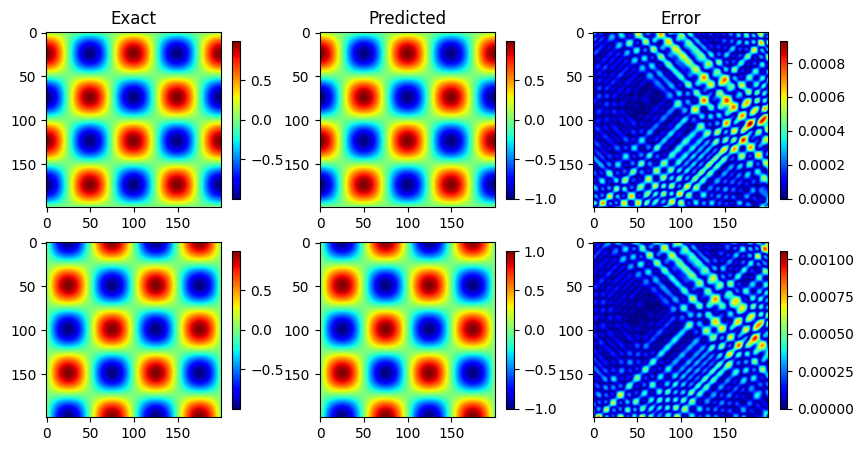

In [10]:
#Testing

with torch.no_grad():
    E_pred = (torch.mv(WTest, c[0].cpu()) + b[0].cpu()).reshape(n_test, n_test).detach().numpy()
    H_pred = (torch.mv(WTest, c[1].cpu()) + b[1].cpu()).reshape(n_test, n_test).detach().numpy()


E_errL2 = (np.sum(np.abs(E_exact-E_pred)**2))**0.5 / (np.sum(np.abs(E_exact)**2))**0.5
E_errMax = np.max(np.abs(E_exact-E_pred))

H_errL2 = (np.sum(np.abs(H_exact-H_pred)**2))**0.5 / (np.sum(np.abs(H_exact)**2))**0.5
H_errMax = np.max(np.abs(H_exact-H_pred))

print(f'E:  RelativeL2: {E_errL2}, '
      f'Max: {E_errMax} \n\n'
      f'B:  RelativeL2: {H_errL2}, '
      f'Max: {H_errMax}')

fig = plt.figure(1, figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(E_exact, cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Exact')

plt.subplot(2,3,2)
plt.imshow(E_pred, cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Predicted')

plt.subplot(2,3,3)
plt.imshow(abs(E_exact-E_pred), cmap='jet')
plt.colorbar(shrink=0.9)
plt.title('Error')

fig = plt.figure(1, figsize=(20,30))
plt.subplot(2,3,4)
plt.imshow(H_exact, cmap='jet')
plt.colorbar(shrink=0.9)

plt.subplot(2,3,5)
plt.imshow(H_pred, cmap='jet')
plt.colorbar(shrink=0.9)

plt.subplot(2,3,6)
plt.imshow(abs(H_exact-H_pred), cmap='jet')
plt.colorbar(shrink=0.9)

# plt.savefig('sol.png')
plt.show()